# Environmental SetUp 

In [1]:
# General
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
import plotly.express as px
import matplotlib.pyplot as plt

# Data Preprocessing
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split

# Model
from keras.applications import VGG16

# Model training
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, GlobalAveragePooling2D
from keras.layers import InputLayer

# Model Callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

2024-04-05 05:51:00.211689: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 05:51:00.211798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 05:51:00.330351: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Setting constants for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224

# EDA ON OUR DATASET

Total number of images  : 23708
Sample Image path       : 1_0_3_20161220222642427.jpg.chip.jpg
Sample Age              : 1
Sample Gender           : Male



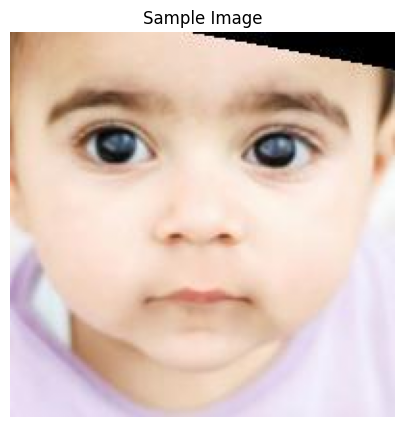

In [3]:
# Initialize the directory path
dir_path = "/kaggle/input/utkface-new/UTKFace/"
image_paths = os.listdir(dir_path)

# Initialize a Gender Mapping
gender_mapping = ["Male", "Female"]

# Choose and load an image randomly
rand_image_path = np.random.choice(image_paths)
rand_image = plt.imread(dir_path + rand_image_path)/255.
sample_age, sample_gender, *_ = rand_image_path.split("_")

print(f"Total number of images  : {len(image_paths)}")
print(f"Sample Image path       : {rand_image_path}")
print(f"Sample Age              : {sample_age}")
print(f"Sample Gender           : {gender_mapping[int(sample_gender)]}\n")

# Show the image
plt.figure(figsize = (5,5))
plt.title("Sample Image")
plt.imshow(rand_image)
plt.axis("off")
plt.show()

In [4]:
# Initialize a male counter variable
male_count = 0

# Initialize variable to store all the ages.
ages = []

# Loop over the paths and check for male images.
for path in image_paths:
    path_split = path.split("_")
    if "0" == path_split[1]:
        male_count += 1
    ages.append(int(path_split[0]))

# Computee total female counts
female_count = len(image_paths) - male_count

# Visualizing The Class Imbalance
pie_chart = px.pie(
    names = gender_mapping,
    values = [male_count, female_count],
    hole = 0.4,
    title = "Gender Distribution (Donut Chart)",
    height = 500
)
pie_chart.show()

bar_graph = px.bar(
    y = gender_mapping,
    x = [male_count, female_count],
    title = "Gender Distribution (Bar Graph)",
    color = gender_mapping,
    height = 500
)
bar_graph.update_layout(
    yaxis_title = "Gender",
    xaxis_title = "Frequency Count"
)
bar_graph.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [6]:
# Histogram
fig = px.histogram(sorted(ages), title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Value Counts"
)
fig.show()

In [7]:
# SHuffling the Images
np.random.shuffle(image_paths)

# Split data into training, testing and validation set
train_images, test_images = train_test_split(
    image_paths,
    train_size = 0.9,
    test_size = 0.1
)

train_images, valid_images = train_test_split(
    image_paths,
    train_size = 0.9,
    test_size = 0.1
)

print(f"Training Size : {len(train_images)}")
print(f"Testing Size  : {len(test_images)}")

# Extract age and gender
train_ages = [int(path.split("_")[0]) for path in train_images]
train_genders = [int(path.split("_")[1]) for path in train_images]

valid_ages = [int(path.split("_")[0]) for path in valid_images]
valid_genders = [int(path.split("_")[1]) for path in valid_images]

test_ages = [int(path.split("_")[0]) for path in test_images]
test_genders = [int(path.split("_")[1]) for path in test_images]

Training Size : 21337
Testing Size  : 2371


In [8]:
def preprocess_age_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    # Load the Image
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)

    # Resize and Normalize the Image
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)

    return image, age

In [9]:
# Obtain training, testing and validation datasets
train_ds = tfds.Dataset.from_tensor_slices((train_images, train_ages, train_genders)).shuffle(2000)
train_age_ds = train_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

In [10]:
valid_ds = tfds.Dataset.from_tensor_slices((valid_images, valid_ages, valid_genders)).shuffle(2000)
valid_age_ds = valid_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

In [11]:
test_ds  = tfds.Dataset.from_tensor_slices((test_images, test_ages, test_genders)).shuffle(500)
test_age_ds = test_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

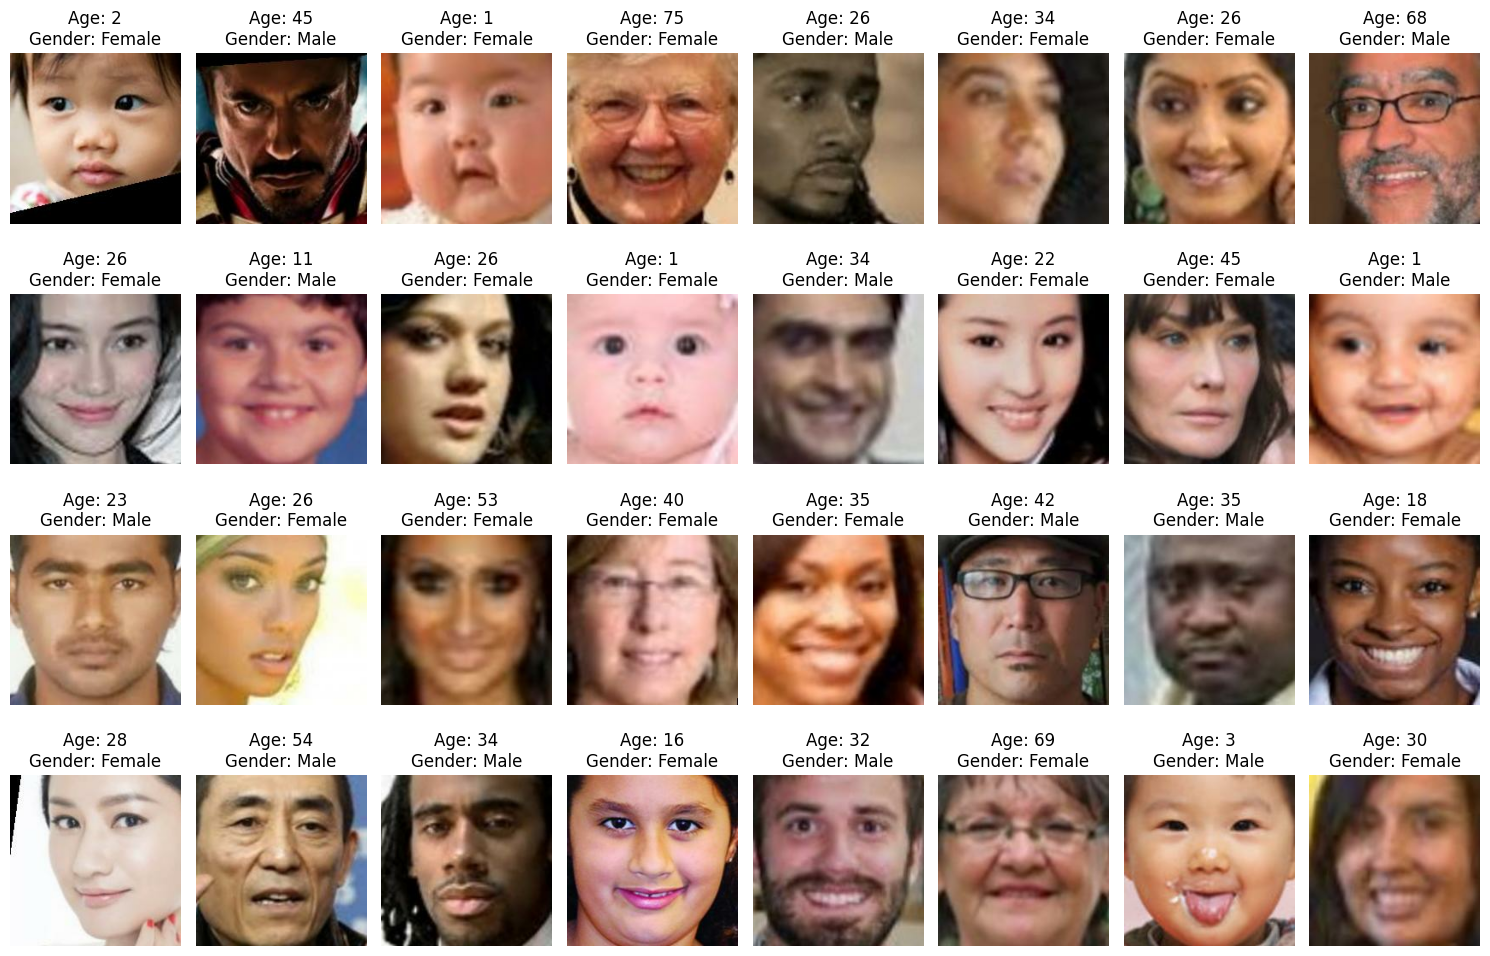

In [12]:
plt.figure(figsize=(15, 10))
for images, ages, genders in train_ds.batch(BATCH_SIZE).take(1):

    for index in range(len(images)):
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        plt.subplot(4, 8, index + 1)
        plt.imshow(image)
        plt.title(f"Age: {ages[index]}\nGender: {gender_mapping[genders[index]]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
input_shape = (224, 224, 3)

# RESNET50 Age Network 

In [14]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [15]:
backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
model = Sequential()
model.add(backbone)
    
    #now we will add our custom layers
    #without drop layer, neural networks can easily overfit
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
    
    #final layer, since we are doing regression we will add only one neuron (unit)
model.add(Dense(1, activation='relu'))
optimizer = Adam(lr=0.0003)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
print(model.summary())


94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 23536641 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
None


In [16]:
# Trining the Age Model
age_history =model.fit(
    train_age_ds,
    validation_data = valid_age_ds,
    epochs = 20,
    batch_size = BATCH_SIZE
)

Epoch 1/20


2024-04-05 05:52:16.300579: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1712296341.204504     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


667/667 [==============================] - 183s 222ms/step - loss: 8.6021 - mae: 8.6021 - val_loss: 14.9888 - val_mae: 14.9888
Epoch 2/20
667/667 [==============================] - 139s 208ms/step - loss: 7.0041 - mae: 7.0041 - val_loss: 8.1721 - val_mae: 8.1721
Epoch 3/20
667/667 [==============================] - 139s 208ms/step - loss: 6.4546 - mae: 6.4546 - val_loss: 7.9933 - val_mae: 7.9933
Epoch 4/20
667/667 [==============================] - 139s 208ms/step - loss: 6.0330 - mae: 6.0330 - val_loss: 8.6851 - val_mae: 8.6851
Epoch 5/20
667/667 [==============================] - 139s 208ms/step - loss: 5.6298 - mae: 5.6298 - val_loss: 6.7465 - val_mae: 6.7465
Epoch 6/20
667/667 [==============================] - 139s 208ms/step - loss: 5.3180 - mae: 5.3180 - val_loss: 6.5857 - val_mae: 6.5857
Epoch 7/20
667/667 [==============================] - 139s 208ms/step - loss: 5.0571 - mae: 5.0571 - val_loss: 6.8194 - val_mae: 6.8194
Epoch 8/20
667/667 [==============================] - 139

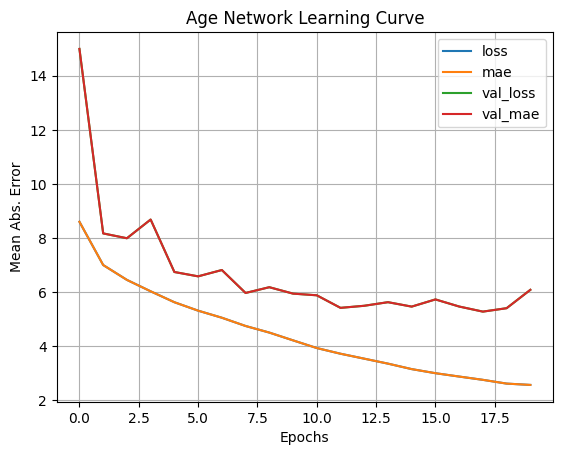

In [24]:
# Converting history into data frame.
age_his_df = pd.DataFrame(age_history.history)

# Visualization
age_his_df.plot()
plt.title("Age Network Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Mean Abs. Error")
plt.grid()
plt.show()

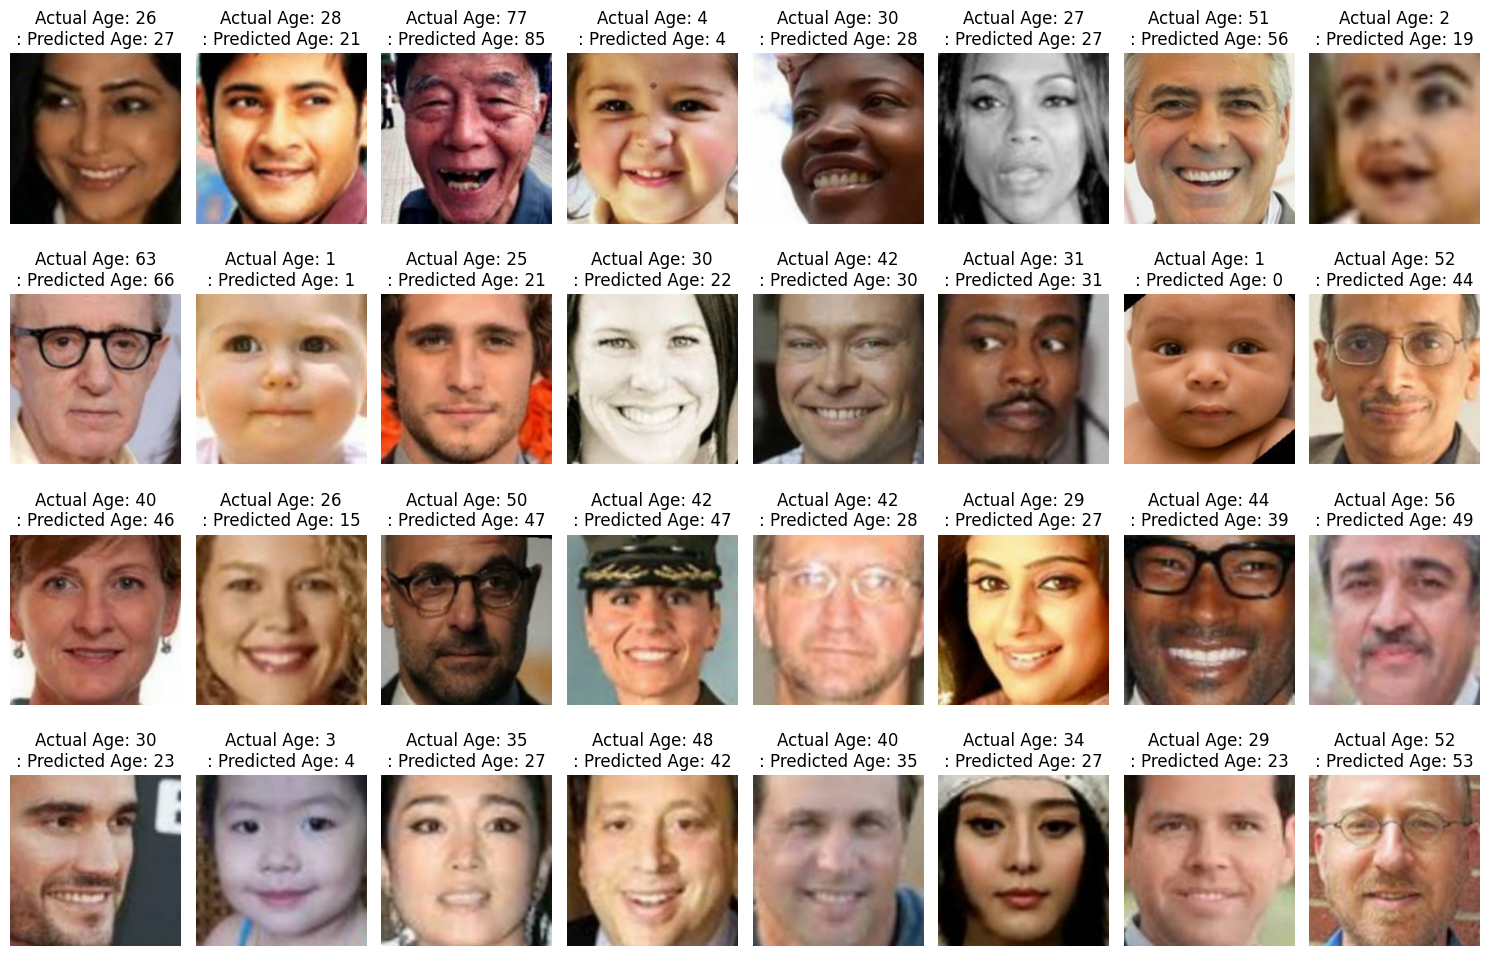

In [21]:
plt.figure(figsize=(15, 10))
for images, ages, genders in test_ds.batch(BATCH_SIZE).take(2):
    for index in range(len(images)):

        # Image Processing
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        image = tf.cast(image, tf.float32)
        image = image/255.
        image = tf.image.resize(image, [224,224])
        image = tf.reshape(image, [-1,224,224,3])
        
        # Predictions
        pred_age = tf.round(tf.squeeze(model.predict(image, verbose=0)), 2)

        # Visualization
        plt.subplot(4, 8, index + 1)
        plt.imshow(image[0])
        plt.title(f"Actual Age: {ages[index]}\n: Predicted Age: {int(pred_age)}")
        plt.axis("off")

plt.tight_layout()
plt.show()